1. 데이터 다운로드

In [ ]:
TRAIN_FOLDER_PATH = './input/dataset/train/'


TEST_FOLDER_PATH = './input/dataset/test'



In [53]:
import os
import shutil
import zipfile

# 폴더 생성 (기존재시 pass)
os.makedirs('./input',  exist_ok=True)
os.makedirs('./output', exist_ok=True)

# 데이터 다운로드(api key 세팅 참조 링크 : https://github.com/Kaggle/kaggle-api)
!kaggle competitions download -c kdtai-3

# 압축 해제 후 input 에 train.csv test.csv  넣기
zipfile.ZipFile(f'./kdtai-3.zip').extractall('./input')

def move_file(source_path, destination_path):
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        
move_file('./input/dataset/train/train_output.csv', './input/dataset/train_output.csv')
move_file('./input/dataset/test/test_output.csv', './input/dataset/test_output.csv')

kdtai-3.zip: Skipping, found more recently modified local copy (use --force to force download)


2. 이미지 width, hegith 정보 집어넣기

In [54]:
import pandas as pd

train = pd.read_csv('./input/dataset/train_output.csv')
test = pd.read_csv('./input/dataset/test_output.csv')

In [55]:
from PIL import Image

def get_img_info(dir, file):
    file = str(int(file)).zfill(4) + ".jpg"
    img_path = os.path.join(dir, file)
    
    image = Image.open(img_path)
    width, height = image.width, image.height
    
    return width, height

In [56]:
train['image_width'], train['image_height'] = zip(*train.apply(
    lambda row: get_img_info("./input/dataset/train/", row['filename']), axis=1)
)

test['image_width'], test['image_height'] = zip(*test.apply(
    lambda row: get_img_info("input/dataset/test/", row['filename']), axis=1)
)

In [57]:
all = pd.concat([train, test]).reset_index(drop=True)
all[:10]

,filename,label,image_width,image_height
0,1,1 0.438281 0.529551 0.814063 0.704492,640,423
1,2,3 0.541016 0.524324 0.849219 0.672973,1992,1328
2,3,2 0.492500 0.517045 0.695000 0.725000,600,440
3,4,2 0.585156 0.525000 0.692187 0.785135,1600,1065
4,5,3 0.385547 0.645270 0.614844 0.698649\n3 0.559...,800,450
5,6,1 0.429688 0.596737 0.590625 0.778555,640,429
6,7,3 0.516797 0.504054 0.380469 0.929730,960,640
7,8,0 0.476526 0.520833 0.298122 0.404167,852,480
8,9,2 0.461184 0.470783 0.435774 0.877711\n2 0.813...,2499,1660
9,10,3 0.700781 0.626042 0.532813 0.739583,640,480


3. 기존 label 과 이미지 높이 너비 붙어있는  것 box_region, 과 label 로 나누기

label_1 center_x1, center_y1, width_1, width_2 \n label_2, center_x2, center_y2, width_2, height_2 

---


label 별 box_region 별 나누기

In [58]:
def seperate_label(label):
    box_regions = []
    labels = []
    regions = label.split('\n')
    for region in regions:
        box_label = region.split()[0]
        box_region = " ".join(region.split()[1:])
        box_regions.append(box_region)
        labels.append(box_label)
    return '\n'.join(box_regions),'\n'.join(labels)

In [59]:
# 첫 번째 정수만 추출하여 새로운 컬럼 'extracted_label'에 저장
all['box_regions'], all['labels'] = zip(*all['label'].apply(seperate_label))
all.drop(columns=['label'], inplace=True)
all.head()

,filename,image_width,image_height,box_regions,labels
0,1,640,423,0.438281 0.529551 0.814063 0.704492,1
1,2,1992,1328,0.541016 0.524324 0.849219 0.672973,3
2,3,600,440,0.492500 0.517045 0.695000 0.725000,2
3,4,1600,1065,0.585156 0.525000 0.692187 0.785135,2
4,5,800,450,0.385547 0.645270 0.614844 0.698649\n0.559375 ...,3\n3\n3


In [60]:
# 새로운 데이터프레임 생성
new_rows = []

# 데이터프레임 이터레이션
for _, row in all.iterrows():
    filename = row["filename"]
    box_regions = row["box_regions"]
    labels = row["labels"]
    image_width = row["image_width"]
    image_height = row["image_height"]

    # box_regions와 labels를 \n으로 분할하여 여러 개의 행 생성
    box_regions = box_regions.split("\n")
    labels = labels.split("\n")

    # 분할된 box_regions와 labels를 개별적으로 처리하여 새로운 행 생성
    for box_region, label in zip(box_regions, labels):
        new_row = {
            "filename": filename, 
            "box_regions": box_region, 
            "labels": label, 
            "image_height": image_height,
            "image_width" : image_width
        }
        new_rows.append(new_row)

# 새로운 데이터프레임 생성
new_all = pd.DataFrame(new_rows)

new_all.rename(columns={'box_regions': 'box_region',
                        'labels' : 'label'}, inplace=True)
# box_region을 center_x, center_y, width, height로 나누기
new_all[['center_x', 'center_y', 'width', 'height']] = new_all['box_region'].str.split(' ', expand=True).astype(float)
new_all.drop(columns=["box_region"], inplace=True)

new_all[:10]

,filename,label,image_height,image_width,center_x,center_y,width,height
0,1,1,423,640,0.438281,0.529551,0.814063,0.704492
1,2,3,1328,1992,0.541016,0.524324,0.849219,0.672973
2,3,2,440,600,0.492500,0.517045,0.695000,0.725000
3,4,2,1065,1600,0.585156,0.525000,0.692187,0.785135
4,5,3,450,800,0.385547,0.645270,0.614844,0.698649
5,5,3,450,800,0.559375,0.682432,0.445313,0.629730
6,5,3,450,800,0.143359,0.382432,0.286719,0.318919
7,6,1,429,640,0.429688,0.596737,0.590625,0.778555
8,7,3,640,960,0.516797,0.504054,0.380469,0.929730
9,8,0,480,852,0.476526,0.520833,0.298122,0.404167


In [61]:
print(f"새롭게 생긴 데이터 프레임 길이 : {len(new_all)}")

새롭게 생긴 데이터 프레임 길이 : 2685


In [62]:
all = new_all

all['box_width'] = all['width'] * all['image_width']
all['box_height'] = all['height'] * all['image_height']

all['box_left_top_x'] = (all['center_x'] * all['image_width']) - (all['width'] * all['image_width'])/2
all['box_left_top_y'] = (all['center_y'] * all['image_height']) - (all['height'] * all['image_height'])/2

all.drop(columns=["center_x", "center_y", "width", "height"], inplace=True)
all.head()

,filename,label,image_height,image_width,box_width,box_height,box_left_top_x,box_left_top_y
0,1,1,423,640,521.000320,298.000116,19.999680,75.000015
1,2,3,1328,1992,1691.644248,893.708144,231.881748,249.448200
2,3,2,440,600,417.000000,319.000000,87.000000,67.999800
3,4,2,1065,1600,1107.499200,836.168775,382.500000,141.040613
4,5,3,450,800,491.875200,314.392050,62.500000,133.175475


In [65]:
train_coco = all[all["filename"] <= 1204].reset_index().copy().drop(columns=['index'])
test_coco = all[all["filename"] > 1204].reset_index().copy().drop(columns=['index'])

In [66]:
train_coco.head()

,filename,label,image_height,image_width,box_width,box_height,box_left_top_x,box_left_top_y
0,1,1,423,640,521.000320,298.000116,19.999680,75.000015
1,2,3,1328,1992,1691.644248,893.708144,231.881748,249.448200
2,3,2,440,600,417.000000,319.000000,87.000000,67.999800
3,4,2,1065,1600,1107.499200,836.168775,382.500000,141.040613
4,5,3,450,800,491.875200,314.392050,62.500000,133.175475


In [67]:
test_coco.head()

,filename,label,image_height,image_width,box_width,box_height,box_left_top_x,box_left_top_y
0,1205,1,426,640,388.00000,258.999906,230.00000,75.999891
1,1205,1,426,640,126.00000,93.000060,70.00032,249.999804
2,1205,1,426,640,308.00000,194.999796,134.00000,128.000220
3,1206,3,427,640,235.00032,302.000020,332.99968,118.000169
4,1206,3,427,640,150.00000,315.000035,137.00000,85.000114


In [33]:
print(f"train coco 길이 : {len(train_coco)}")
print(f"test coco 길이 : {len(test_coco)}")

train coco 길이 : 2127
test coco 길이 : 558


test/ train 폴더에서 각각 이미지 좌우반전후 이름정할시에는 + 5000 한걸로 하긔

In [68]:
def flip_image(folder_path, image_name):
    # 이미지 열기
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)

    # 이미지 좌우 반전
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # 반전된 이미지 저장
    new_image_name = 5000 + int(image_name.replace('.jpg',''))
    new_image_path = os.path.join(folder_path, str(new_image_name)+".jpg")
    flipped_image.save(new_image_path)


In [69]:
for tmp_image in os.listdir('./input/dataset/train'):
    flip_image('./input/dataset/train/', tmp_image)
    
for tmp_image in os.listdir('./input/dataset/test'):
    flip_image('./input/dataset/test/', tmp_image)

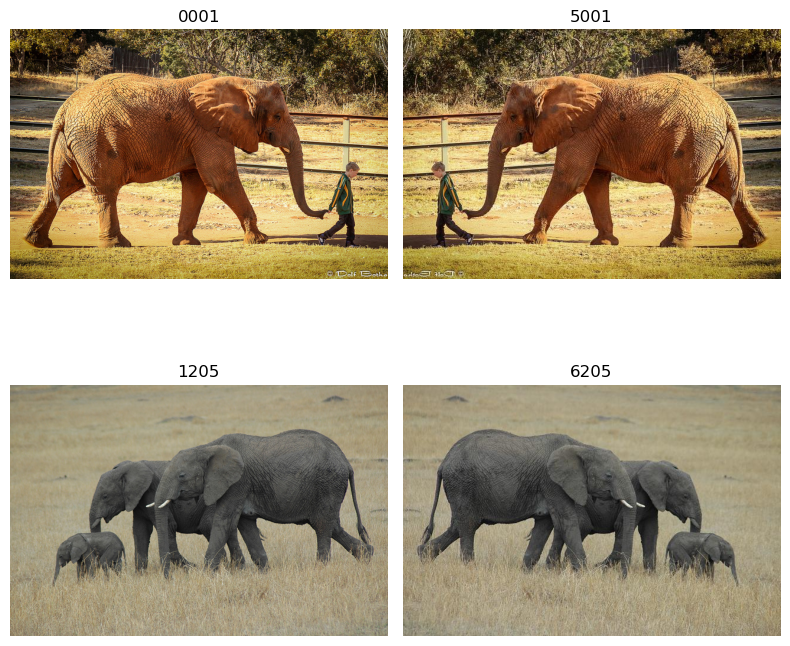

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_image_grid(image_paths):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        image_path = image_paths[i]
        image = mpimg.imread(image_path)
        ax.imshow(image)
        ax.axis('off')
        title = os.path.splitext(os.path.basename(image_path))[0]
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

# 사용 예시
image_paths = [
    './input/dataset/train/0001.jpg',
    './input/dataset/train/5001.jpg',
    './input/dataset/test/1205.jpg',
    './input/dataset/test/6205.jpg'
]

plot_image_grid(image_paths)

In [89]:
def add_flip_row(df):
    new_df = []
    for idx in range(len(df)):
        tmp_row = df.iloc[idx]
        # box_width - box_right_top 구하고 
        tmp_row["box_left_top_x"] = tmp_row["image_width"] - (tmp_row["box_left_top_x"] + tmp_row["box_width"])
        tmp_row["filename"] += 5000 
        new_df.append(tmp_row)
    new_df = pd.DataFrame(new_df)
    ret_df = pd.concat([new_df, df]).reset_index(drop=True)
        
    return ret_df    
flip_added_all = add_flip_row(all)
flip_added_all.head()

C:\Users\user\AppData\Local\Temp\ipykernel_29792\304912696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_row["box_left_top_x"] = tmp_row["image_width"] - (tmp_row["box_left_top_x"] + tmp_row["box_width"])
C:\Users\user\AppData\Local\Temp\ipykernel_29792\304912696.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_row["filename"] += 5000


,filename,label,image_height,image_width,box_width,box_height,box_left_top_x,box_left_top_y
0,5001,1,423,640,521.000320,298.000116,99.000000,75.000015
1,5002,3,1328,1992,1691.644248,893.708144,68.474004,249.448200
2,5003,2,440,600,417.000000,319.000000,96.000000,67.999800
3,5004,2,1065,1600,1107.499200,836.168775,110.000800,141.040613
4,5005,3,450,800,491.875200,314.392050,245.624800,133.175475


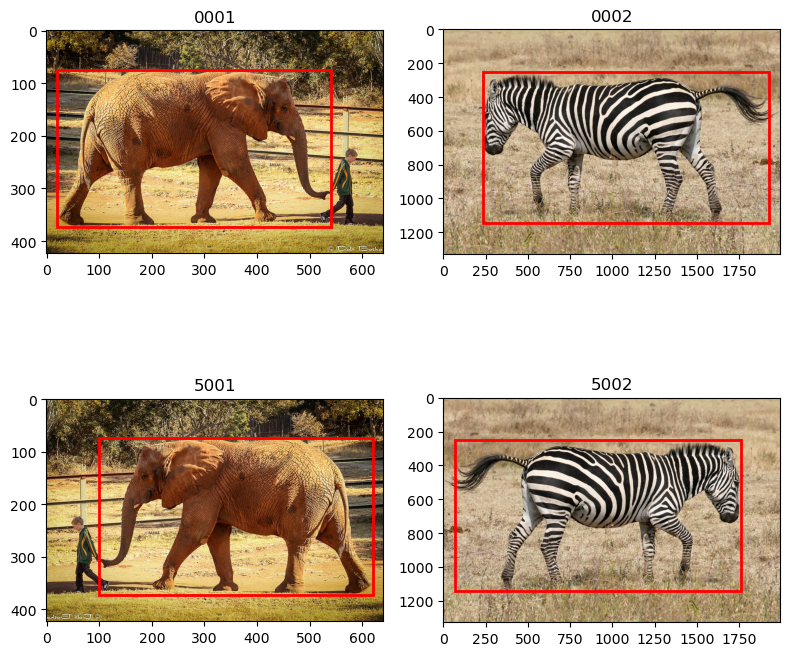

In [98]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

def visualize_bounding_boxes(folder_path, df, imgs):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()

    for i, (filename, ax) in enumerate(zip(imgs, axes)):
        # 이미지 파일 경로
        image_path = os.path.join(folder_path, f"{filename}.jpg")
        # 이미지 로드
        image = plt.imread(image_path)

        # 이미지를 현재 축에 표시
        ax.imshow(image)
        ax.set_title(filename)
        # 해당 파일의 bounding box 정보 추출
        file_df = df[df['filename'] == int(filename)]
        # bounding box 정보를 반복하며 각각의 box를 그림
        for _, row in file_df.iterrows():
            box_width = row['box_width']
            box_height = row['box_height']
            box_left_top_x = row['box_left_top_x']
            box_left_top_y = row['box_left_top_y']

            # bounding box의 왼쪽 상단 좌표와 크기를 사용하여 Rectangle 패치 생성
            # rect = patches.Rectangle((box_left_top_x, box_left_top_y),
            #                          box_width, box_height,
            #                          linewidth=2, edgecolor='r', facecolor='none')
            
            rect = patches.Rectangle((box_left_top_x, box_left_top_y),
                                     box_width, box_height,
                                     linewidth=2, edgecolor='r', facecolor='none')

            # Rectangle 패치를 그림
            ax.add_patch(rect)
        
        # 축 설정
        # ax.axis('off')

    # 그림 출력
    plt.tight_layout()
    plt.show()

# 사용 예시
imgs = ['0001','0002','5001', '5002']  # 이미지 파일명 리스트

# bounding box 시각화
visualize_bounding_boxes('./input/dataset/train/', flip_added_all, imgs)

In [100]:
# Train, Test 파일 각각 갯수 세기
from glob import glob

print("기존 1204개, 300개에서 좌우대칭 된것 까지 추가됬음")
print(f'훈련 데이터 개수 : {len(glob("./input/dataset/train/" + "*.jpg"))}')
print(f'테스트 데이터 개수 : {len(glob("./input/dataset/test/" + "*.jpg"))}')

기존 1204개, 300개에서 좌우대칭 된것 까지 추가됬음
훈련 데이터 개수 : 2408
테스트 데이터 개수 : 600


In [103]:
print(f"기존 dataframe 갯수 : {len(all)}")
print(f"새롭게 생성된 dataframe 갯수 : {len(flip_added_all)}")
print(f"기존 train_coco 갯수 : {len(train_coco)}")
print(f"기존 test_coco 갯수 : {len(test_coco)}")

기존 dataframe 갯수 : 2685
새롭게 생성된 dataframe 갯수 : 5370
기존 train_coco 갯수 : 2127
기존 test_coco 갯수 : 558


In [102]:
flip_added_all

,filename,label,image_height,image_width,box_width,box_height,box_left_top_x,box_left_top_y
0,5001,1,423,640,521.000320,298.000116,99.000000,75.000015
1,5002,3,1328,1992,1691.644248,893.708144,68.474004,249.448200
2,5003,2,440,600,417.000000,319.000000,96.000000,67.999800
3,5004,2,1065,1600,1107.499200,836.168775,110.000800,141.040613
4,5005,3,450,800,491.875200,314.392050,245.624800,133.175475
...,...,...,...,...,...,...,...,...
5365,1501,2,1053,1560,1317.468360,680.181138,41.437500,280.325448
5366,1502,1,596,885,797.191185,480.827172,57.386497,109.534966
5367,1503,1,720,960,369.749760,248.108400,58.500480,384.324120
5368,1503,1,720,960,582.000000,496.216080,282.749760,123.567480


In [107]:
flip_added_train_coco = flip_added_all[
    ((flip_added_all["filename"] >= 1) & (flip_added_all["filename"] <= 1204)) # 1~1204
    |  # or
    ((flip_added_all["filename"] >= 1+5000) & (flip_added_all["filename"] <= 1204+5000)) # 1+5000 ~ 1204+5000
].reset_index().copy().drop(columns=['index'])

flip_added_test_coco = flip_added_all[
    ((flip_added_all["filename"] >= 1205) & (flip_added_all["filename"] <= 1504 )) # 1205~1504
    |  # or
    ((flip_added_all["filename"] >= 1205+5000) & (flip_added_all["filename"] <= 1504+5000)) # 1+1205 ~ `+1504
].reset_index().copy().drop(columns=['index'])

In [108]:
print(f"기존 train_coco 갯수 : {len(train_coco)}")
print(f"기존 test_coco 갯수 : {len(test_coco)}")
print(f"새로 생성된 train_coco 갯수 : {len(flip_added_train_coco)}")
print(f"새로 생성된  test_coco 갯수 : {len(flip_added_test_coco)}")

기존 train_coco 갯수 : 2127
기존 test_coco 갯수 : 558
새로 생성된 train_coco 갯수 : 4254
새로 생성된  test_coco 갯수 : 1116


train_coco , test_coco annotation.json 으로 생성후에 각 test/train 폴더 속에 집어넣기

In [110]:
info_dict = {"info": {
    "year":"2022","version":"1",
    "description":"Exported from roboflow.ai",
    "contributor":"",
    "url":"https://public.roboflow.ai/object-detection/undefined","date_created":"2022-12-17T02:13:57+00:00"
}}

license_dict = {
    "licenses":[{"id":1,"url":"https://creativecommons.org/licenses/by/4.0/","name":"CC BY 4.0"}]
}

categories_dict = {
        "categories":[
        {"id": int(0), "name":"Water buffalo","supercategory":"animal"},
        {"id":int(1), "name":"Elephant","supercategory":"animal"},
        {"id":int(2), "name":"Rhinoceros","supercategory":"animal"},
        {"id":int(3), "name":"Zebra","supercategory":"animal"}
    ]
}

In [114]:
import json

def create_annotation_json(foler_path, df):
    images_dict = {
        "images": []
    }

    annotations_dict = {
        "annotations": []
    }
    
    image_set = set()

    for idx in range(len(df)):
        tmp_series = df.iloc[idx]

        if int(tmp_series['filename']) in image_set:
            continue
        else:
            tmp_image_dict = {
            "id": int(tmp_series['filename']),
            "file_name": str(int(tmp_series['filename'])).zfill(4) + ".jpg",
            "height": int(tmp_series['image_height']),
            "width": int(tmp_series['image_width'])
            }
            images_dict["images"].append(tmp_image_dict)
        
        tmp_annotation_dict = {
            "id": idx,
            "image_id": int(tmp_series['filename']),
            "category_id": int(tmp_series['label']),
            "bbox":[
                int(tmp_series['box_left_top_x']),
                int(tmp_series['box_left_top_y']),
                int(tmp_series['box_width']),
                int(tmp_series['box_height'])
            ],
        }
        annotations_dict["annotations"].append(tmp_annotation_dict)
        
    annotation_dict = {}
    annotation_dict.update(info_dict)
    annotation_dict.update(license_dict)
    annotation_dict.update(categories_dict)
    annotation_dict.update(images_dict)
    annotation_dict.update(annotations_dict)
    
    annotation_path  = os.path.join(foler_path, "_annotations.coco.json")
    
    with open(annotation_path, "w") as json_file:
        json.dump(annotation_dict, json_file)
        
    return 

In [115]:
create_annotation_json('./input/dataset/train/', flip_added_train_coco)
create_annotation_json('./input/dataset/test/', flip_added_test_coco)

모델 가져와서 훈련시킬준비해보자

In [116]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cpu
0.14.0+cpu


In [117]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm
!pip install pycocotools

Looking in indexes: https://test.pypi.org/simple/


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.30.0 which is incompatible.
cached-path 1.1.6 requires filelock<3.9,>=3.4, but you have filelock 3.12.0 which is incompatible.
allennlp 2.10.1 requires filelock<3.8,>=3.3, but you have filelock 3.12.0 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 2.0.0 which is incompatible.
allennlp 2.10.1 requires torchvision<0.14.0,>=0.8.1, but you have torchvision 0.14.0 which is incompatible.
allennlp-models 2.10.1 requires torch<1.13.0,>=1.7.0, but you have torch 2.0.0 which is incompatible.
ERROR: Could not install pac

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__, 
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)